In [104]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [105]:
filename_npz = '/Users/jacaraba/Desktop/testing/tesing_410.npz'
filename_cloud = '/Users/jacaraba/Desktop/CURRENT_PROJECTS/LCLUC_Senegal_Cloud/labels/final/WV02_20101020_0-0_data.tif'
bands = ['CoastalBlue', 'Blue', 'Green', 'Yellow', 'Red', 'RedEdge', 'NIR1', 'NIR2']

In [106]:
#(FDI, SI, NDWI)

# Shadow Index (SI), type int16
def si(data, bands, factor=10000.0, vtype='int16', device='CPU') -> np.array:
    # SI := ((factor - Blue) * (factor - Green) * (factor - Red)) ** (1.0 / 3)
    BLUE, GREEN = bands.index('Blue'), bands.index('Green')
    RED = bands.index('Red')

    si = ((factor - data[BLUE, :, :]) * (factor - data[GREEN, :, :]) *
          (factor - data[RED, :, :])) ** (1.0/3.0)

    si = si.expand_dims(dim="band", axis=0).fillna(0).astype(vtype)
    return si, "SI"


# Normalized Difference Water Index (NDWI), type int16
def ndwi(data, bands, factor=1.0, vtype='int16', device='CPU') -> np.array:
    # 8 and 4 band imagery: NDWI := factor * (Green - NIR1) / (Green + NIR1)
    GREEN, NIR1 = bands.index('Green'), bands.index('NIR1')

    ndwi = factor * ((data[GREEN, :, :] - data[NIR1, :, :])
                     / (data[GREEN, :, :] + data[NIR1, :, :]))

    ndwi = ndwi.expand_dims(dim="band", axis=0).fillna(0).astype(vtype)
    return ndwi, "NDWI"


# Forest Discrimination Index (FDI), type int16
def fdi(data, bands, factor=1.0, vtype='int16', device='CPU') -> np.array:
    # 8 band imagery: FDI := NIR2 - (RedEdge + Blue)
    # 4 band imagery: FDI := NIR1 - (Red + Blue)
    NIR = bands.index('NIR2') if 'NIR2' in bands else bands.index('NIR1')
    RED = bands.index('RedEdge') if 'RedEdge' in bands else bands.index('Red')
    BLUE = bands.index('Blue')
    fdi = data[NIR, :, :] - (data[RED, :, :] + data[BLUE, :, :])
    fdi = fdi.expand_dims(dim="band", axis=0).fillna(0).astype(vtype)
    return fdi, "FDI"

def ndvi(data, bands, factor=1.0, vtype='float64', device='CPU') -> np.array:
    # 8 and 4 band imagery: NDVI := (NIR - Red) / (NIR + RED)
    NIR1, Red = bands.index('NIR1'), bands.index('Red')
    return (((data[NIR1, :, :] / factor) - (data[Red, :, :] / factor)) /
            ((data[NIR1, :, :] / factor) + (data[Red, :, :] / factor))
            ).expand_dims(dim="band", axis=0).fillna(0).astype(vtype), "NDVI"

def cs1(data, bands, factor=1.0, vtype='float64', device='CPU') -> np.array:
    # 8 and 4 band imagery: CS1 := (3. * NIR1) / (Blue + Green + Red)
    NIR1, Blue = bands.index('NIR1'), bands.index('Blue')
    Green, Red = bands.index('Green'), bands.index('Red')
    return ((3.0 * (data[NIR1, :, :]/factor)) / (data[Blue, :, :]
            + data[Green, :, :] + data[Red, :, :])
            ).expand_dims(dim="band", axis=0).fillna(0).astype(vtype), "CS1"

def cs2(data, bands, factor=1.0, vtype='float64', device='CPU') -> np.array:
    # 8 and 4 band imagery: CS2 := (Blue + Green + Red + NIR1) / 4.
    NIR1, Blue = bands.index('NIR1'), bands.index('Blue')
    Green, Red = bands.index('Green'), bands.index('Red')
    return ((data[Blue, :, :] + data[Green, :, :] + data[Red, :, :]
            + data[NIR1, :, :]) / 4.0
            ).expand_dims(dim="band", axis=0).fillna(0).astype(vtype), "CS2"


In [107]:
# open dataset
xx = xr.open_rasterio(filename_cloud)
xx

<xarray.DataArray (band: 8, y: 5000, x: 5000)>
[200000000 values with dtype=int16]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8
  * y        (y) float64 1.564e+06 1.564e+06 1.564e+06 ... 1.554e+06 1.554e+06
  * x        (x) float64 4.994e+05 4.994e+05 4.994e+05 ... 5.094e+05 5.094e+05
Attributes:
    transform:      (2.0, 0.0, 499385.0, 0.0, -2.0, 1564309.0)
    crs:            +init=epsg:32628
    res:            (2.0, 2.0)
    is_tiled:       0
    nodatavals:     (-10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

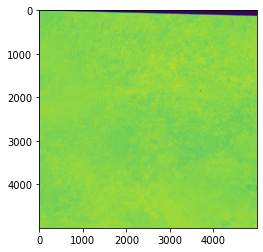

In [108]:
vis = xx[6, :, :].values
plt.imshow(vis)
plt.show()

-6602.305044155067 -0.0 -3449.6797054708522


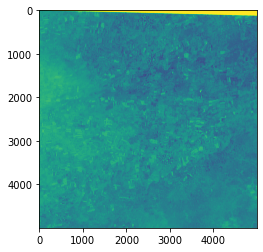

In [109]:
ndwi, ndwiid = ndwi(xx, bands, factor=10000.0, vtype='float64', device='CPU')
vis2 = ndwi[0,:,:].values
print(vis2.min(), vis2.max(), vis2.mean())
plt.imshow(vis2)
plt.show()

5953.897741436833 20000.99999999999 8828.661623919294


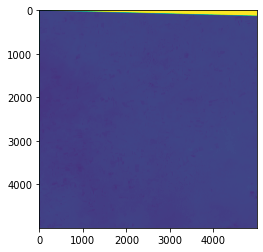

In [110]:
sii, siid = si(xx, bands, factor=10000.0, vtype='float64', device='CPU')
vis3 = sii[0,:,:].values
print(vis3.min(), vis3.max(), vis3.mean())
plt.imshow(vis3)
plt.show()

-4178.0 10001.0 -803.37596528


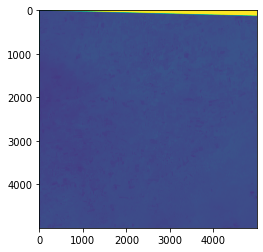

In [111]:
fdii, fdiid = fdi(xx, bands, factor=10000.0, vtype='float64', device='CPU')
vis4 = fdii[0,:,:].values
print(vis4.min(), vis4.max(), vis4.mean())
plt.imshow(vis4)
plt.show()

-0.0 0.7595177664974619 0.38672174563830203


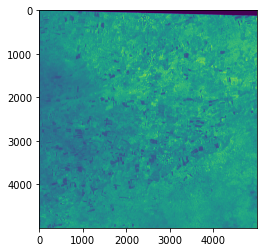

In [112]:
ndvii, ndviid = ndvi(xx, bands, factor=1.0, vtype='float64', device='CPU')
vis5 = ndvii[0,:,:].values
print(vis5.min(), vis5.max(), vis5.mean())
plt.imshow(vis5)
plt.show()

1.0 5.403702500811952 2.1092550059780124


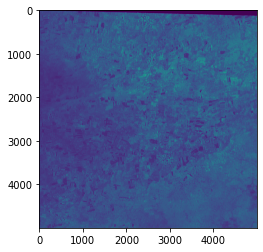

In [113]:
cs1ii, cs1iid = cs1(xx, bands, factor=1.0, vtype='float64', device='CPU')
vis6 = cs1ii[0,:,:].values
print(vis6.min(), vis6.max(), vis6.mean())
plt.imshow(vis6)
plt.show()

1060.0 6383.0 1795.47145458


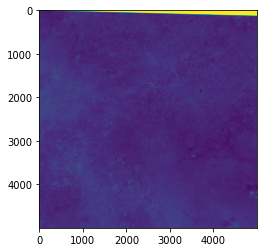

In [114]:
cs2ii, cs2iid = cs2(xx, bands, factor=1.0, vtype='float64', device='CPU')
vis7 = cs2ii[0,:,:].values
print(vis7.min(), vis7.max(), vis7.mean())
plt.imshow(vis7)
plt.show()